In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [186]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist
from src.utils import printProgBar, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [187]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [ ]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors
mods = {'mod4_rbc_vanilla': {'params': mod4_params,
                             'priors': mod4_priors,
                             'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda']},
        'mod5_nk_vanilla': {'params': mod5_params,
                            'priors': mod5_priors,
                            'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'w', 'r', 'lambda', 'pi', 'pi_obj']}}

# load model
for item in mods.keys():
    mods[item]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{item}.gcn'), verbose=False)

# solve model
for item in mods.keys():
    _, mods[item]['mod'] = solve_updated_mod(mods[item]['mod'], verbose=False)
    assert _ == True

# load posterior estimates
for key in mods.keys():
    file_name = get_most_recent_mod_output(POST_EST_DIR, key)
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

mod4_rbc_vanilla_20230326_2048.nc
mod5_nk_vanilla_20230326_2021.nc


load posterior estimation data

In [ ]:
name = 'mod4_rbc_vanilla'
xarr = mods[name]['post_out']
mod = mods[name]['mod']
prior_dist = mods[name]['priors']
plot_vars = mods[name]['plot_vars']
mod_params = mods[name]['params']

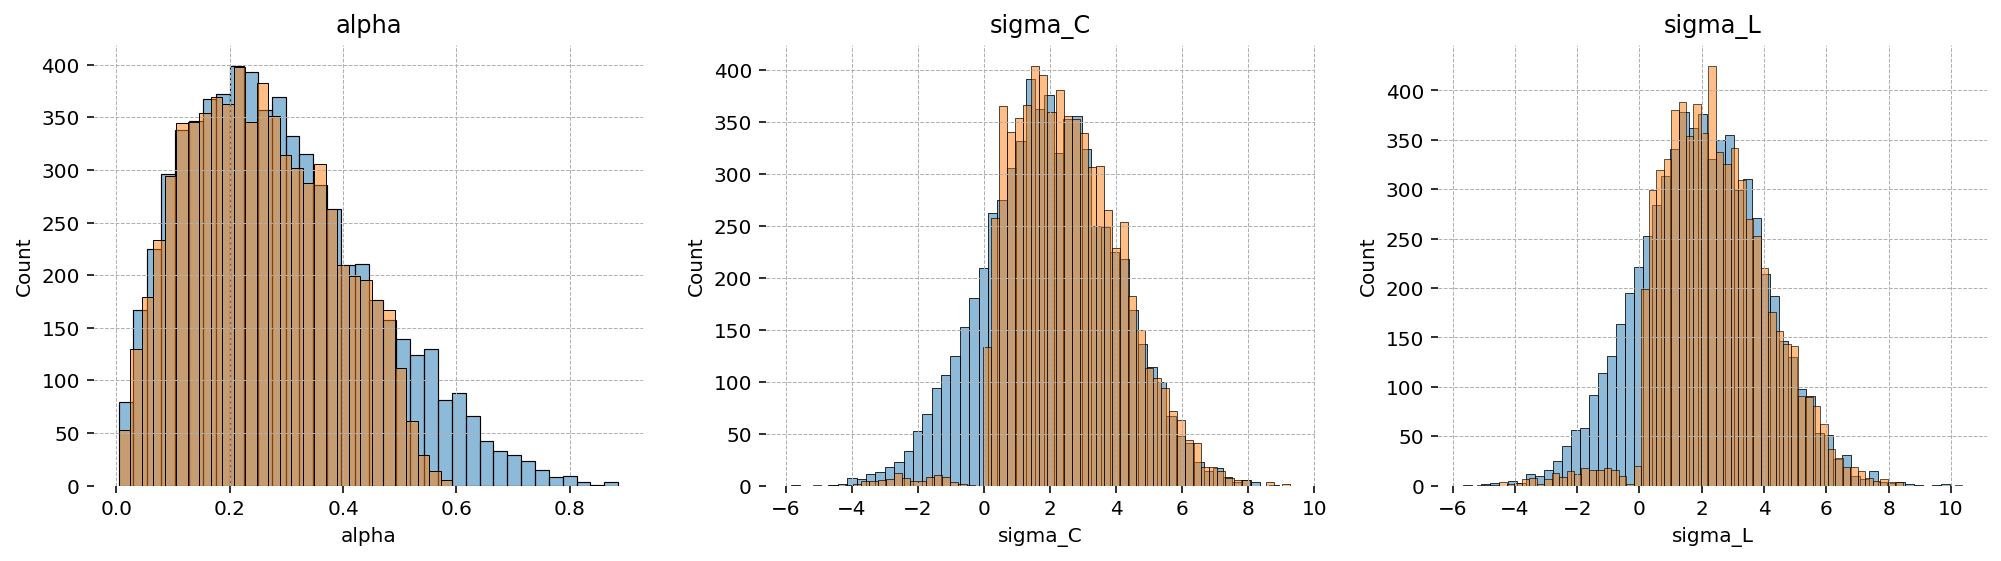

In [ ]:
n_runs = xarr.n_runs_acc.values
x1 = pd.DataFrame(xarr.posterior[int(n_runs/2):], columns=xarr.parameter)
x2 = pd.DataFrame([[prior_dist[param].rvs() for item in range(0, int(n_runs/2))] for param in xarr.parameter.values],
                  index=xarr.parameter).transpose()
plot_dfs(dfs_data=[x2, x1], plotfunc=sns.histplot, alpha=.5, legend=['prior', 'posterior'])

### filterpy

In [ ]:
if not 'pi' in [item.base_name for item in mod.variables]:
    if 'pi' in train.columns: train.drop('pi', axis=1, inplace=True), test.drop('pi', axis=1, inplace=True)

In [193]:
# shock_size = .1
# sim_length = 120

# param_sets = [{param: float(xarr.sel(parameter=param).posterior_q1.values) for param in xarr.parameter.values},
#               {param: float(xarr.sel(parameter=param).posterior_mean.values) for param in xarr.parameter.values},
#               {param: float(xarr.sel(parameter=param).posterior_q2.values) for param in xarr.parameter.values}]

# posterior_params1 = dict(zip(xarr.parameter.values, xarr.posterior_q2.values.round(3)))
# posterior_params1 = dict(zip(
#     xarr.parameter.values, 
#     xarr.sel(draw=np.where(xarr.log_like==np.min(xarr.log_like).values)[0][0]).posterior.values
# ))
# posterior_params2 = dict(zip(
#     xarr.parameter.values, 
#     xarr.sel(draw=400).posterior.values
# ))
# param_sets = [posterior_params1, posterior_params2]

# irfs = []
# # get irf for each model
# for i, params in enumerate(param_sets):
#     mod.free_param_dict.update(params)
#     irfs.append(mod.impulse_response_function(simulation_length=sim_length, shock_size=shock_size))
#     mod.free_param_dict.update(mod_params)
    

# # set plotting shock
# shock = 'epsilon_A'
# for i, irf in enumerate(irfs):
#     irfs[i] = irf.unstack().loc[:, shock].unstack().copy()

# # plot shocks
# plot_dfs([df for df in irfs],
#          sns.lineplot,
#          figsize=(15, 4),
#          # legend=['1', '2', '3']
#         )

In [194]:
def solve_updated_mod(mod, verbose: bool = True, **kwargs) -> (bool, object):
    """

    :param mod:
    :param verbose:
    :param kwargs: solver, default is cycle_reduction, 'gensys' also supported
    :return:
    """
    # solve for steady state
    mod.steady_state(verbose=verbose)
    is_solved = mod.steady_state_solved
    if not is_solved:
        return False, mod

    # solve model, capture np.LinAlgEr
    try:
        mod.solve_model(verbose=verbose, **kwargs)
    except np.linalg.LinAlgError:
        if verbose: print("LinAlg Erorr in solving")
        return False, mod

    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool', verbose=verbose)

    return is_solved & is_bk, mod

In [201]:
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y"]

# update mod params with posterior mean
mod.free_param_dict.update(mod_params)

posterior_params = dict(zip(xarr.parameter.values, xarr.posterior_q2.values.round(3)))
posterior_params = dict(zip(
    xarr.parameter.values, 
    xarr.sel(draw=np.where(xarr.log_like==np.min(xarr.log_like).values)[0][0]).posterior.values
))

_, shocks = sample_from_priors(prior_dist, mod_params, shock_names)
mod.free_param_dict.update(posterior_params)

solved, mod = solve_updated_mod(mod, verbose=False)
if not solved: raise ValueError


T, R = mod.T.values, mod.R.values
H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                          shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables, H0=.01)

kfilter = KalmanFilter(len(state_variables), len(observed_vars))
kfilter.F = mod.T
kfilter.Q = QN
kfilter.H = Z
kfilter.R = H

In [202]:
def kalman_filter_forecast(kfilter, data):
    mu, cov, ll = [],[],[]
    zs = data.copy()
    for i, z in enumerate(zs):
        kfilter.predict()
        mu.append(kfilter.x)
        cov.append(kfilter.P)
        
        kfilter.update(z)
        ll.append(kfilter.log_likelihood)
        
    return np.array(mu), np.array(cov), np.array(ll)

In [203]:
saver = Saver(kfilter)
mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
ll = saver.log_likelihood
print(np.sum(ll))
mu_df = pd.DataFrame(mu.reshape(len(mu), -1),
                     columns=[item.base_name for item in mod.variables],
                     index=train.index)
cov_df = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=train.index)

-77.54195090143605


In [204]:
mu, cov, ll = kalman_filter_forecast(kfilter, test[observed_vars].values)
print(np.sum(ll))

mu_df_test = pd.DataFrame(mu.reshape(len(mu), -1),
                     columns=[item.base_name for item in mod.variables],
                     index=test.index)
cov_df_test = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=test.index)

-19.002772827895377


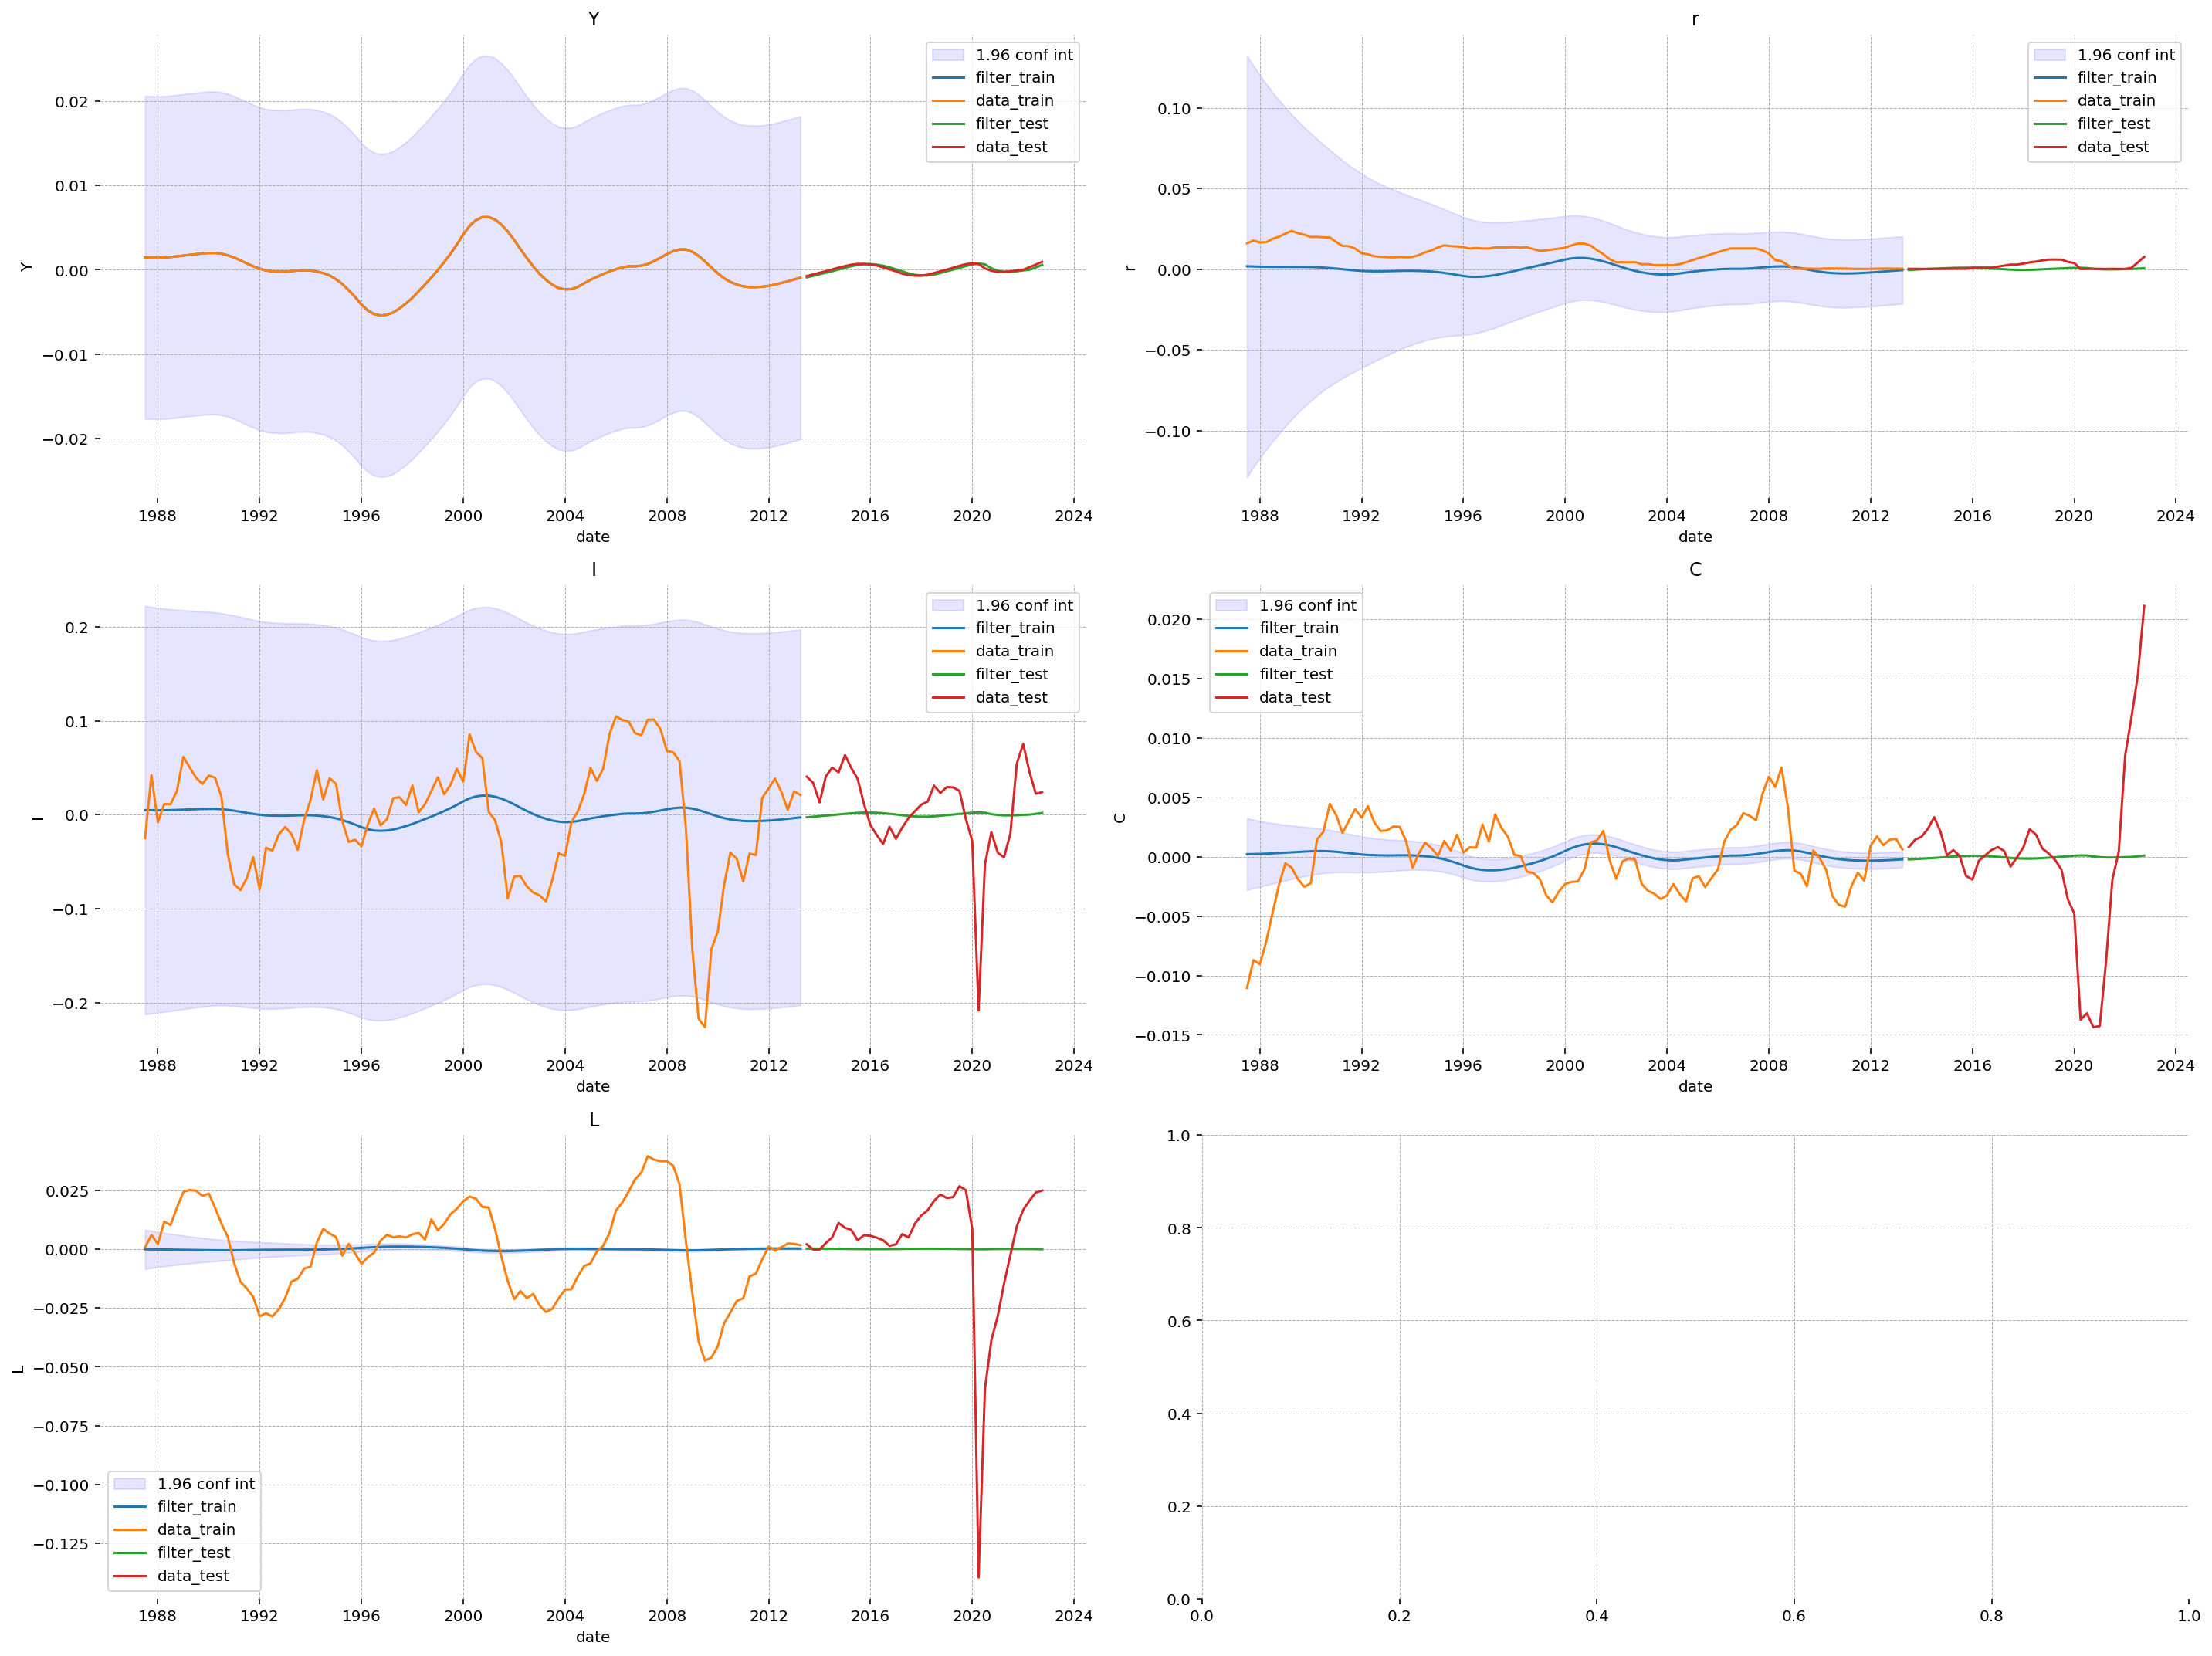

In [206]:
ind = 50
plot_dfs([
    mu_df[train.columns].iloc[ind:], 
    train.iloc[ind:], 
    mu_df_test[train.columns],
    test
         ], 
    plotfunc=sns.lineplot, 
    dfs_cov=[
        cov_df.iloc[ind:],
        None, 
        # cov_df_test
        None,
        None
    ],
    legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
    cols=2,
    figsize=(20, 5)
)

get ARMA process

In [207]:
from statsmodels.tsa.arima.model import ARIMA

In [213]:
col = 'I'
arima = ARIMA(train[col].values, order=(2, 0, 1))
arima_res = arima.fit()

# arima_res.summary()
mu_df = pd.DataFrame(arima_res.predict(), index=train.index).rename(columns={0: col})

In [219]:
forecasts = []
for i in range(0, len(test[col])):
    forecasts.append(arima_res.forecast(1))
    arima_res = arima_res.apply(endog=[test[col].iloc[i]])
forecasts = pd.DataFrame(forecasts, columns=[col], index=test.index)

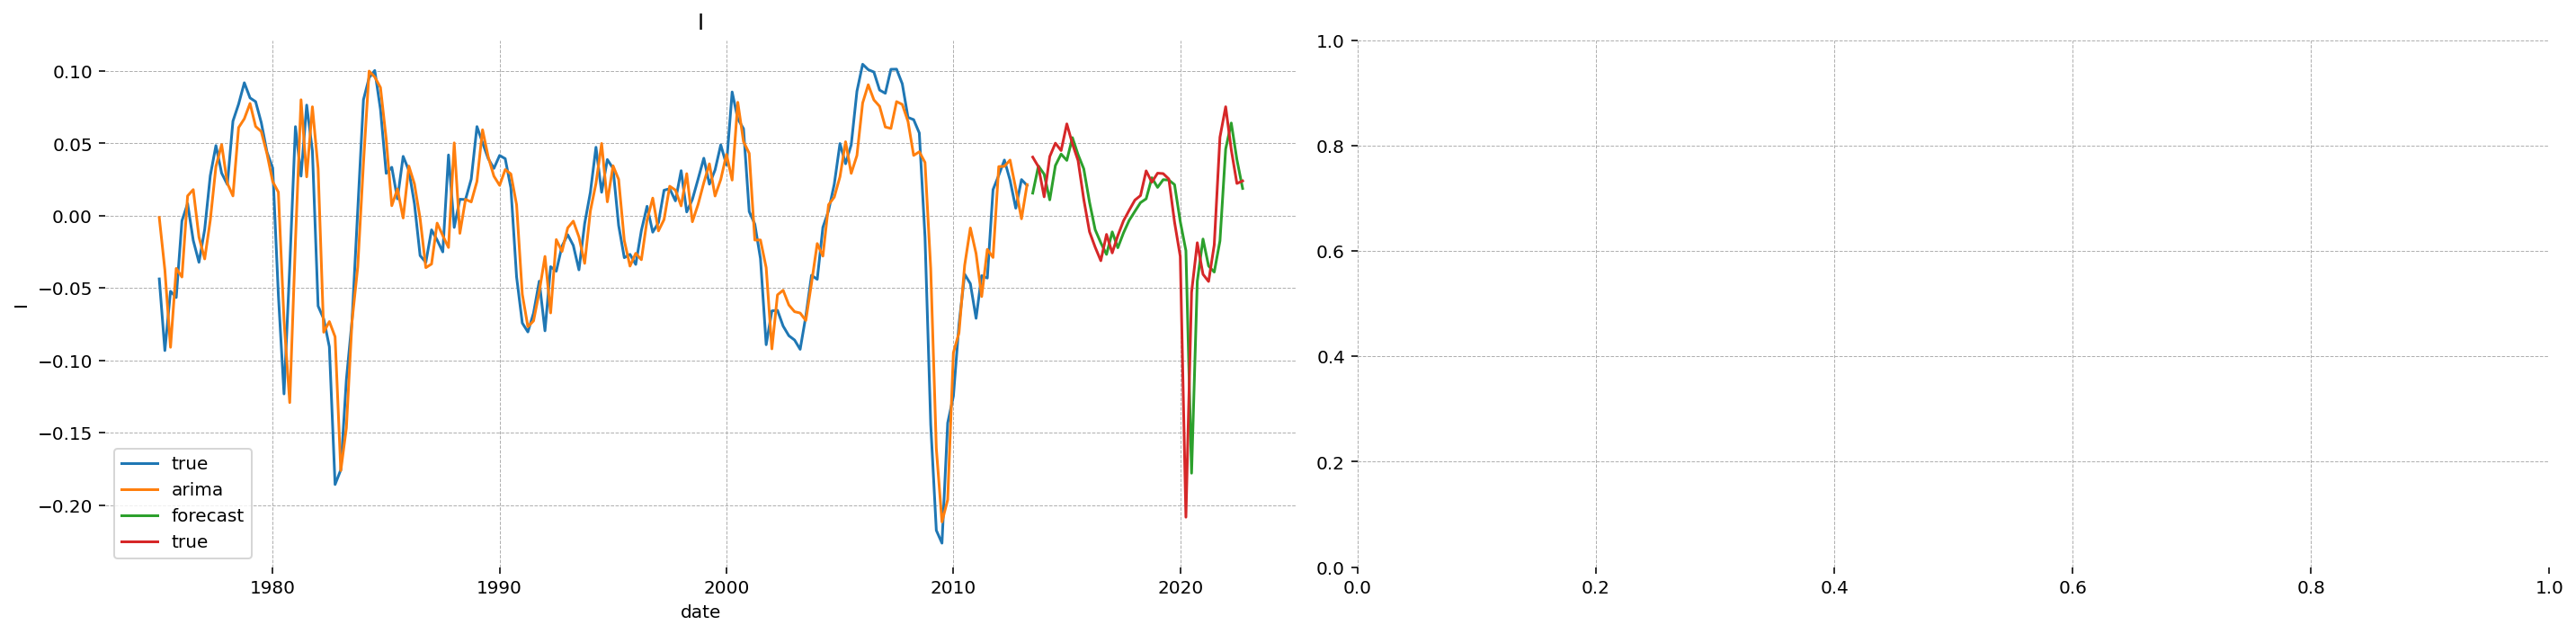

In [220]:
plot_dfs([
    train[[col]],
    mu_df,
    forecasts, 
    test[[col]]], sns.lineplot, cols=2,
    legend=['true', 'arima', 'forecast', 'true'],
    figsize=(20, 5)
)